# Part 6

In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
map_month = {'Jan' : '01',
             'Feb' : '02',
             'Mar' : '03',
             'Apr' : '04',
             'May' : '05',
             'Jun' : '06',
             'Jul' : '07',
             'Aug' : '08',
             'Sep' : '09',
             'Oct' : '10',
             'Nov' : '11',
             'Dec' : '12'}

In [3]:
def convert_timestamp(t):
    time_str = t[-4:] + '-' + map_month[t[4:7]] + '-' + t[8:19]
    return time.mktime(time.strptime(time_str,'%Y-%m-%d %H:%M:%S'))

In [9]:
#----------------------Function to extract the data from the file--------------
def extract_info(hashtag):
    hashtag_dictionary = {'#GoHawks' : ['tweets_#gohawks.txt', 188136],
                          '#GoPatriots' : ['tweets_#gopatriots.txt', 26232]}
                       
    #-----------------------Extracting data from the file----------------------    
    time_since_register = [0]*hashtag_dictionary[hashtag][1]
    default_profile = [0]*hashtag_dictionary[hashtag][1]
    no_of_favourites = [0]*hashtag_dictionary[hashtag][1]
    no_of_followers = [0]*hashtag_dictionary[hashtag][1]
    no_of_friends = [0]*hashtag_dictionary[hashtag][1]
    geo_enabled  =[0]*hashtag_dictionary[hashtag][1]
    is_translator = [0]*hashtag_dictionary[hashtag][1]
    no_of_listed = [0]*hashtag_dictionary[hashtag][1]
    protected = [0]*hashtag_dictionary[hashtag][1]
    verified = [0]*hashtag_dictionary[hashtag][1]
    total_no_of_tweets = [0]*hashtag_dictionary[hashtag][1]
       
    file_in = open('./Training_data/'+hashtag_dictionary[hashtag][0], encoding = "utf8")

    for (line, index) in zip(file_in, range(0, hashtag_dictionary[hashtag][1])):
        tr_data = json.loads(line)
        time_since_register[index] = tr_data['firstpost_date']-convert_timestamp(tr_data['tweet']['user']['created_at'])
        default_profile[index] = 1 if tr_data['tweet']['user']['default_profile'] else 0
        no_of_favourites[index] = tr_data['tweet']['user']['favourites_count']
        no_of_followers[index] = tr_data['tweet']['user']['followers_count']
        no_of_friends[index] = tr_data['tweet']['user']['friends_count']
        geo_enabled [index] = 1 if tr_data['tweet']['user']['geo_enabled'] else 0
        is_translator[index] = 1 if tr_data['tweet']['user']['is_translator'] else 0
        no_of_listed[index] = tr_data['tweet']['user']['listed_count']
        protected[index] = 1 if tr_data['tweet']['user']['protected'] else 0
        verified[index] = 1 if tr_data['tweet']['user']['verified'] else 0
        total_no_of_tweets[index] = tr_data['tweet']['user']['statuses_count']
        
    file_in.close()
        
    #------------------To build the DataFrame and save it to file--------------
    extracted_data = np.array([time_since_register,
                                default_profile,
                                no_of_favourites,
                                no_of_followers,
                                no_of_friends,
                                geo_enabled,
                                is_translator,
                                no_of_listed,
                                protected,
                                verified,
                                total_no_of_tweets])
    extracted_data = np.transpose(extracted_data)

    data_frame = DataFrame(extracted_data)
    data_frame.columns = ['time_since_register',
                          'default_profile',
                          'no_of_favourites',
                          'no_of_followers',
                          'no_of_friends',
                          'geo_enabled',
                          'is_translator',
                          'no_of_listed',
                          'protected',
                          'verified',
                          'total_no_of_tweets']

    if os.path.isdir('./Extracted_data'):
        pass
    else:
        os.mkdir('./Extracted_data')
    data_frame.to_csv('./Extracted_data/part6_'+hashtag+'.csv', index = False)   
#------------------------------------------------------------------------------

In [10]:
#-------------------Function to perform RF Regression----------------------
def RF_regression(hashtag):
    training_data = pd.read_csv('./Extracted_data/part6_'+hashtag+'.csv')
        
    #---------------------------RF Regression------------------------------
    target_data = training_data.pop('total_no_of_tweets')
    
    reg = RandomForestRegressor(n_estimators = 20, max_depth = 80)
    reg_result = reg.fit(training_data, target_data)
       
    predicted_values = reg_result.predict(training_data)

    #------------------Printing the results and scatter plots -----------------
    fig, ax = plt.subplots()
    ax.scatter(target_data, predicted_values)
    ax.plot([target_data.min(), target_data.max()], [target_data.min(), target_data.max()], 'k--', lw = 4)
    ax.set_xlabel('Actual values', fontsize = 20)
    ax.set_ylabel('Predicted values', fontsize = 20)
    plt.title('Predicted values vs. Actual values (' + hashtag + ')', fontsize = 20)
    plt.show()
    
    plt.clf
    fig, ax = plt.subplots()
    ax.scatter(target_data, (predicted_values - target_data)/target_data)
    ax.plot([0,max(target_data)], [0,0], 'k--', lw = 4)
    ax.set_xlabel('Actual values', fontsize = 20)
    ax.set_ylabel('Relative Errors', fontsize = 20)
    plt.title('Relative Errors vs. Actual values (' + hashtag + ')', fontsize = 20)
    plt.show()

    total_error = 0.0
    for (actual, predicted) in zip(target_data, predicted_values):
        total_error += abs(actual - predicted)
    print('Average prediction error:',total_error/len(target_data))
#------------------------------------------------------------------------------
  

In [11]:
def perform_RF_regression(hashtag):
    print('-------------------------------------------------------')
    print('Processing hashtag "' + hashtag + '".\n')
    extract_info(hashtag)
    RF_regression(hashtag)

-------------------------------------------------------
Processing hashtag "#GoHawks".



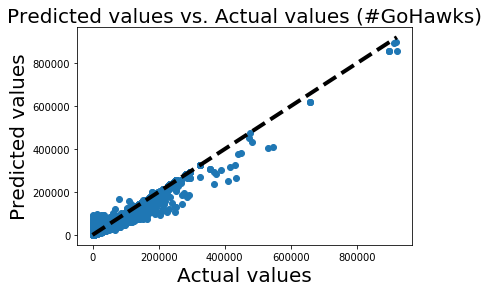

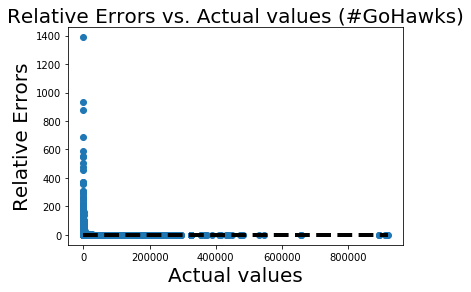

Average prediction error: 715.0985896119477
-------------------------------------------------------
Processing hashtag "#GoPatriots".



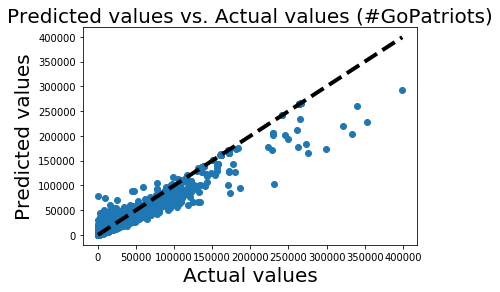

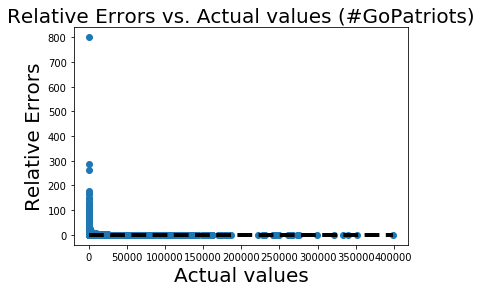

Average prediction error: 1601.9012405513472


In [12]:
perform_RF_regression('#GoHawks')
perform_RF_regression('#GoPatriots')